In [47]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.sparse import csc_matrix
from scipy.sparse import lil_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import pandas as pd

In [48]:
df = pd.read_csv("../datasets/creditcard_2023.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V20     568630 non-null  float64
 21  V21     56

In [58]:
df = df.sample(n=10000, random_state=42)
print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 475968 to 272207
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      10000 non-null  int64  
 1   V1      10000 non-null  float64
 2   V2      10000 non-null  float64
 3   V3      10000 non-null  float64
 4   V4      10000 non-null  float64
 5   V5      10000 non-null  float64
 6   V6      10000 non-null  float64
 7   V7      10000 non-null  float64
 8   V8      10000 non-null  float64
 9   V9      10000 non-null  float64
 10  V10     10000 non-null  float64
 11  V11     10000 non-null  float64
 12  V12     10000 non-null  float64
 13  V13     10000 non-null  float64
 14  V14     10000 non-null  float64
 15  V15     10000 non-null  float64
 16  V16     10000 non-null  float64
 17  V17     10000 non-null  float64
 18  V18     10000 non-null  float64
 19  V19     10000 non-null  float64
 20  V20     10000 non-null  float64
 21  V21     10000 non-null  float64
 2

In [59]:
data = df.values
# print(data.isnull().sum())
# # Удаление строк с пропущенными значениями
# data_cleaned = data.dropna()
X = data[: , 1:-1]
y = data[: , -1]



In [60]:
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Обучение scaler на обучающих данных и одновременное их масштабирование
X_train = scaler.fit_transform(X_train)

# Применение того же масштабирования к тестовым данным
X_test = scaler.transform(X_test)

In [61]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

In [62]:
def rbf_kernel(x1, x2, sigma=1.0):
    return np.exp(-np.linalg.norm(x1 - x2)**2 / (2 * (sigma**2)))

In [54]:
class SVM:
    def __init__(self, kernel='linear', C=100, epsilon=1e-5, sigma=1.0):
        self.kernel = kernel
        self.C = C
        self.epsilon = epsilon
        self.sigma = sigma
        self.support_indices = None

    def linear_kernel(self, x1, x2):
        return np.dot(x1, x2)

    def rbf_kernel(self, x1, x2):
        return np.exp(-np.linalg.norm(x1 - x2)**2 / (2 * (self.sigma**2)))

    def compute_kernel_matrix(self, X):
        n_samples = X.shape[0]
        kernel_matrix = lil_matrix((n_samples, n_samples))

        for i in range(n_samples):
            for j in range(i, n_samples):
                if self.kernel == 'linear':
                    kernel_matrix[i, j] = self.linear_kernel(X[i], X[j])
                    kernel_matrix[j, i] = kernel_matrix[i, j]  # Матрица Грама симметрична
                elif self.kernel == 'rbf':
                    kernel_matrix[i, j] = self.rbf_kernel(X[i], X[j])
                    kernel_matrix[j, i] = kernel_matrix[i, j]

        return kernel_matrix.tocsr()

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Вычисление ядра для матрицы
        kernel_matrix = self.compute_kernel_matrix(X)

        # Добавление регуляризации к матрице Грама
        gram_matrix = kernel_matrix + self.epsilon * np.identity(n_samples)

        # Формулировка задачи квадратичного программирования
        P = gram_matrix
        q = -np.ones(n_samples)
        G = np.vstack([-np.eye(n_samples), np.eye(n_samples)])
        h = np.hstack([np.zeros(n_samples), np.ones(n_samples) * self.C])

        # Решение задачи квадратичного программирования
        alpha = np.linalg.solve(P, q)
        alpha = np.maximum(0, alpha)
        alpha = np.minimum(self.C, alpha)

        # Нахождение оптимального вектора весов
        if self.kernel == 'linear':
            self.w = np.dot(X.T, alpha * y)
        elif self.kernel == 'rbf':
            self.support_indices = np.arange(n_samples)[(alpha > 0) & (alpha < self.C)]
            self.w = np.sum((alpha[self.support_indices] * y[self.support_indices]).reshape(-1, 1) * X[self.support_indices], axis=0)

        # Сохранение опорных векторов и их меток
        self.support_vectors = X[self.support_indices]
        self.support_labels = y[self.support_indices]

    def predict(self, X):
        if self.kernel == 'linear':
            return np.sign(np.dot(X, self.w))
        elif self.kernel == 'rbf':
            n_samples = X.shape[0]
            predictions = np.zeros(n_samples)

            for i in range(n_samples):
                kernel_values = np.array([self.rbf_kernel(X[i], x) for x in self.support_vectors])
                predictions[i] = np.sign(np.sum(kernel_values * self.support_labels))

            return predictions.astype(int)

In [57]:
svm_linear = SVM(kernel='linear')
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)
accuracy_linear = accuracy_score(y_test, y_pred_linear)
print(f"Accuracy with linear kernel: {accuracy_linear}")

Accuracy with linear kernel: 0.964


In [45]:
# Инициализация SVM с RBF ядром
svm_rbf = SVM(kernel='rbf')
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
print(f"Accuracy with RBF kernel: {accuracy_rbf}")

Accuracy with RBF kernel: 0.9616666666666667


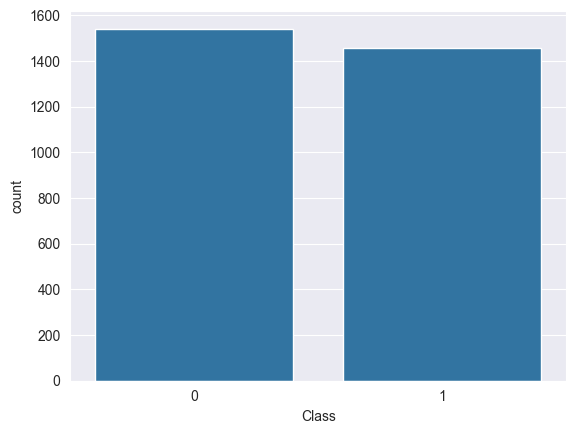

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# График распределения классов
sns.countplot(x='Class', data=df)
plt.show()

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

print("Best Parameter for C:", grid_search.best_params_)

Best Parameter for C: {'C': 100}


In [29]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10]}
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

print("Best Parameters for C and gamma:", grid_search.best_params_)


Best Parameters for C and gamma: {'C': 1, 'gamma': 0.1}


In [ ]:
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

print("Best Parameters for C and Kernel:", grid_search.best_params_)